In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam

## Descriptive Analysis

In [8]:
schedule = pd.read_csv('schedule.csv',encoding='UTF-8 ',sep = ',')
schedule.head()

,date,home,visitor,h,v,ot
0,Pe 14.9.2018,JYP,HIFK,3.0,4.0,1.0
1,Pe 14.9.2018,KalPa,Jukurit,3.0,4.0,1.0
2,Pe 14.9.2018,KooKoo,SaiPa,5.0,6.0,1.0
3,Pe 14.9.2018,Lukko,Ässät,2.0,3.0,1.0
4,Pe 14.9.2018,Sport,Pelicans,4.0,2.0,0.0


In [9]:
schedule.mean()

h     2.968889
v     2.566667
ot    0.237778
dtype: float64

In [10]:
print("Max_home goals", schedule['h'].max())
print("Max_vistor goals",schedule['v'].max())

Max_home goals 9.0
Max_vistor goals 8.0


From the result above, we can see that on average, the home team scores more goals than the vistor team.This is the so called 'home (field) advantage'.

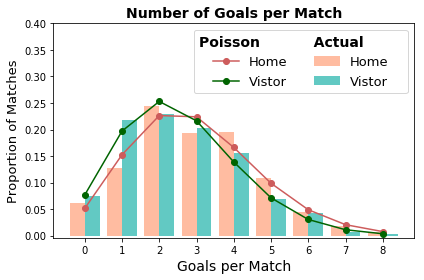

In [11]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, schedule.mean()[j]) for i in range(9)] for j in range(2)])

# plot histogram of actual goals
plt.hist(schedule[['h', 'v']].values, range(10), 
         alpha=0.7, label=['Home', 'Vistor'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,10)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,10)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Vistor", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})


plt.xticks([i-0.5 for i in range(1,10)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=14)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

The plot shows that the actual goals by each team can be approximated by Poisson Distribution. 

## Build Poisson Regression Model

In [12]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([schedule[['home','visitor','h']].assign(homeplay=1).rename(columns={'home':'team', 'visitor':'opponent','h':'goals'}),\
                             schedule[['visitor','home','v']].assign(homeplay=0).rename(columns={'visitor':'team', 'home':'opponent','v':'goals'})])
goal_model_data.head()

,team,opponent,goals,homeplay
0,JYP,HIFK,3.0,1
1,KalPa,Jukurit,3.0,1
2,KooKoo,SaiPa,5.0,1
3,Lukko,Ässät,2.0,1
4,Sport,Pelicans,4.0,1


In [301]:
# Build feature matrix
defen = pd.get_dummies(schedule['home']).astype(float)
offen = pd.get_dummies(schedule['visitor']).astype(float)
home = pd.concat([defen,-offen],axis= 'columns').assign(homeplay=1)
vistor = pd.concat([offen,-defen],axis = 'columns').assign(homeplay=0)
feature = pd.concat([home,vistor],axis = 'index').reset_index(drop = True)
## Rename columns
feature.columns = range(len(feature.columns)) 
for i in range(len(feature.columns)):
    if i < 15:
        feature.rename(columns={feature.columns[i]:"beta{}".format(i+1)},inplace = True)
    elif 15 <= i < 30:
        feature.rename(columns={feature.columns[i]: "alpha{}".format(i+1-15)},inplace = True)
    elif i == 30:
        feature.rename(columns={feature.columns[i] :"u"},inplace = True)
feature.columns

Index(['beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6', 'beta7', 'beta8',
       'beta9', 'beta10', 'beta11', 'beta12', 'beta13', 'beta14', 'beta15',
       'alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5', 'alpha6', 'alpha7',
       'alpha8', 'alpha9', 'alpha10', 'alpha11', 'alpha12', 'alpha13',
       'alpha14', 'alpha15', 'u'],
      dtype='object')

In [278]:
# Define endougeous variable
goals = pd.concat([schedule['h'],schedule['v']],axis= "index").reset_index(drop = True)

In [305]:
np.sum(feature['beta1'][:450])

30.0

In [293]:
# # Construct Possion Regression model
# N_vars = feature.shape[1]
# N_constrs = feature.shape[0]

# m = Model("Possion Regression Model")
# x = m.addVars(N_vars)
# m.update()
# m.addConstrs(sum(feature[i,j]*x[j] for j in range(N_vars)) ==   )
import statsmodels.api as sm
model = sm.GLM(goals,feature,family = sm.families.Poisson())
result = model.fit()
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  900
Model:                            GLM   Df Residuals:                      870
Model Family:                 Poisson   Df Model:                           29
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1644.8
Date:                Tue, 26 Mar 2019   Deviance:                       895.61
Time:                        10:35:56   Pearson chi2:                     789.
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
beta1          0.5795      0.073      7.900      0.000       0.436       0.723
beta2          0.4851      0.076      6.365      0.0

beta1      0.579451
beta2      0.485117
beta3      0.483500
beta4      0.322616
beta5      0.337114
beta6      0.395650
beta7      0.428412
beta8      0.667913
beta9      0.490013
beta10     0.641804
beta11     0.400734
beta12     0.580039
beta13     0.445803
beta14     0.518188
beta15     0.133565
alpha16   -0.490938
alpha17   -0.341470
alpha18   -0.492319
alpha19   -0.401958
alpha20   -0.547177
alpha21   -0.590828
alpha22   -0.637618
alpha23    0.013459
alpha24   -0.478824
alpha25   -0.414315
alpha26   -0.439411
alpha27   -0.689819
alpha28   -0.392300
alpha29   -0.370727
alpha30   -0.635673
u          0.145580
dtype: float64

In [294]:
result.params

beta1      0.579451
beta2      0.485117
beta3      0.483500
beta4      0.322616
beta5      0.337114
beta6      0.395650
beta7      0.428412
beta8      0.667913
beta9      0.490013
beta10     0.641804
beta11     0.400734
beta12     0.580039
beta13     0.445803
beta14     0.518188
beta15     0.133565
alpha16   -0.490938
alpha17   -0.341470
alpha18   -0.492319
alpha19   -0.401958
alpha20   -0.547177
alpha21   -0.590828
alpha22   -0.637618
alpha23    0.013459
alpha24   -0.478824
alpha25   -0.414315
alpha26   -0.439411
alpha27   -0.689819
alpha28   -0.392300
alpha29   -0.370727
alpha30   -0.635673
u          0.145580
dtype: float64

In [219]:

nameDict = {feature.columns[i]:"beta{}".format(i+1) for i in range(15)}
defen.columns = ["beta{}".format(i+1) for i in range(15)]
defen

,beta1,beta2,beta3,beta4,beta5,beta6,beta7,beta8,beta9,beta10,beta11,beta12,beta13,beta14,beta15
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
nameDict

{'HIFK': 'beta1',
 'HPK': 'beta2',
 'Ilves': 'beta3',
 'JYP': 'beta4',
 'Jukurit': 'beta5',
 'KalPa': 'beta6',
 'KooKoo': 'beta7',
 'Kärpät': 'beta8',
 'Lukko': 'beta9',
 'Pelicans': 'beta10',
 'SaiPa': 'beta11',
 'Sport': 'beta12',
 'TPS': 'beta13',
 'Tappara': 'beta14',
 'Ässät': 'beta15'}

In [93]:
feature.rename(columns={feature.columns[i]: "alpha{}".format(i) for i in range(1,16)},inplace= True)
feature.rename(columns={feature.columns[i]: "beta{}".format(i-15) for i in range(16,31)},inplace= True)
fe

ValueError: style is not supported for non-unique indicies.

In [66]:
feature.columns[:14]

Index(['HIFK', 'HPK', 'Ilves', 'JYP', 'Jukurit', 'KalPa', 'KooKoo', 'Kärpät',
       'Lukko', 'Pelicans', 'SaiPa', 'Sport', 'TPS', 'Tappara'],
      dtype='object')

In [14]:
poisson_model = smf.glm(formula="goals ~ homeplay + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  900
Model:                            GLM   Df Residuals:                      870
Model Family:                 Poisson   Df Model:                           29
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1644.8
Date:                Mon, 25 Mar 2019   Deviance:                       895.61
Time:                        22:41:19   Pearson chi2:                     789.
No. Iterations:                     4   Covariance Type:             nonrobust
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.0704      0.111      9.624      0.000       0.852       1.288
team[T.HPK]             -0.0943      0.108     -0.877      0.380      -0.305       0.116
team[T.Ilves]           -0.0960      0.107     -0.895      0.371      -0.306       0.114
team[T.JYP]             -0.2568      0.112     -2.300      0.021      -0.476      -0.038
team[T.Jukurit]         -0.2423      0.112     -2.170      0.030      -0.461      -0.023
team[T.KalPa]           -0.1838      0.110     -1.670      0.095      -0.400       0.032
team[T.KooKoo]          -0.1510      0.109     -1.382      0.167      -0.365       0.063
team[T.Kärpät]           0.0885      0.102      0.866      0.386      -0.112       0.289
team[T.Lukko]           -0.0894      0.107     -0.836      0.403      -0.299       0.120
team[T.Pelicans]         0.0624      0.103      0.606      0.545      -0.139       0.264
team[T.SaiPa]           -0.1787      0.109     -1.633      0.103      -0.393       0.036
team[T.Sport]            0.0006      0.105      0.006      0.996      -0.206       0.207
team[T.TPS]             -0.1336      0.108     -1.237      0.216      -0.345       0.078
team[T.Tappara]         -0.0613      0.106     -0.578      0.563      -0.269       0.146
team[T.Ässät]           -0.4459      0.119     -3.752      0.000      -0.679      -0.213
opponent[T.HPK]         -0.1495      0.113     -1.319      0.187      -0.372       0.073
opponent[T.Ilves]        0.0014      0.109      0.013      0.990      -0.212       0.215
opponent[T.JYP]         -0.0890      0.112     -0.797      0.425      -0.308       0.130
opponent[T.Jukurit]      0.0562      0.108      0.523      0.601      -0.155       0.267
opponent[T.KalPa]        0.0999      0.107      0.937      0.349      -0.109       0.309
opponent[T.KooKoo]       0.1467      0.105      1.394      0.163      -0.060       0.353
opponent[T.Kärpät]      -0.5044      0.126     -3.992      0.000      -0.752      -0.257
opponent[T.Lukko]       -0.0121      0.110     -0.110      0.912      -0.227       0.203
opponent[T.Pelicans]    -0.0766      0.112     -0.685      0.493      -0.296       0.143
opponent[T.SaiPa]       -0.0515      0.110     -0.467      0.641      -0.268       0.165
opponent[T.Sport]        0.1989      0.104      1.906      0.057      -0.006       0.403
opponent[T.TPS]         -0.0986      0.112     -0.879      0.379      -0.318       0.121
opponent[T.Tappara]     -0.1202      0.113     -1.068      0.286      -0.341       0.100
opponent[T.Ässät]        0.1447      0.105      1.379      0.168      -0.061       0.350
homeplay                 0.1456      0.040      3.623      0.000       0.067       0.224
========================================================================================
"""

Possion Regression Model takes the form $\log(E(Y|X)) = \alpha + \beta x$.

The coefficient column is of our interest that implies effect of team/home advantage on goals, i.e., the sign of coefficient value represents the effect on the goals. For example, `homeplay` has `coef` = 0.1456 that captures the fact that the home team score more than vistor team considering `homeplay` variable is binary, which is consistent with the mean of score of home is higher that of vistor. The coefs of team$_i$ and opponent$_i$ reflect the relative strength of team$_i$, e.g., The offensive strength of team `T.Jukurit`= `0.0562`, hence we can say you are more likely to score against team `T.Jukurit`, and the offensive strength = `-0.2423` which represents it scores worse than average.

In [15]:
betting_data = pd.read_csv('betting_data.csv',encoding='ISO-8859-1',sep = '\t')
betting_data['Decimal odds'] = betting_data['Decimal odds'].str.replace(',','.').astype(np.float64)
betting_data['Team'] = betting_data['Team'].replace('Krpt','Kärpät') ## modify the 1st team name 
betting_data

,Team,Decimal odds
0,Kärpät,1.79
1,Tappara,9.13
2,Pelicans,13.27
3,TPS,12.79
4,HIFK,13.70
5,HPK,17.44
6,Lukko,47.95
7,Ilves,95.90
8,JYP,120.00
9,SaiPa,190.00


In [16]:
standings = pd.read_csv('standings.csv',encoding='UTF-8')
standings=standings.rename({'Unnamed: 0':'Team'},axis = 1)
standings.head()

,Team,GP,wins,ties,losses,GF,GA,XP,points,3P,diff,GFpG,GApG
0,Kärpät,60,41,8,11,207,101,6,137,41,106,3.450000,1.683333
1,Tappara,60,32,9,19,177,150,3,108,32,27,2.950000,2.500000
2,Pelicans,60,30,11,19,199,154,3,104,30,45,3.316667,2.566667
3,TPS,60,29,11,20,164,152,5,103,29,12,2.733333,2.533333
4,HPK,60,25,16,19,168,147,8,99,25,21,2.800000,2.450000
